# Setup

In [111]:
import pyphi
import numpy as np
import scipy.io as sio
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import patsy
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import binarize

In [64]:
import warnings
warnings.filterwarnings("ignore")
# UNCOMMENT ABOVE TO CHECK DEPRECATIONS

In [2]:
%matplotlib inline

In [3]:
import pixiedust

Pixiedust database opened successfully


## Immutables

In [4]:
RAW_DATA_DIR = "../data/raw/"
SAMPLE_DATA_FILE = "split2250_bipolarRerefType1_lineNoiseRemoved_postPuffpreStim.mat"

In [5]:
FLY_DATA = sio.loadmat(RAW_DATA_DIR + SAMPLE_DATA_FILE).get("fly_data")

# Processing Functions

In [6]:
def gen_log_reg(data):
    """ Generate logistic regression for binarised past and present states.
    
    Args:
        data (array): (timepoints, channels, trials) array of binarised data.
                      The data will pool each timepoint step as a separate trial.
                      
    Returns: 
        List of Logistic regressions (fitted) for each channel.
    """
    
    n_timepoints, n_channels, n_trials = data.shape
    
    samples = np.zeros((n_channels * 2, (n_trials * (n_timepoints - 1))))
    
    for i_p in range(n_timepoints - 1):
        sliced = data[i_p:i_p+2, :, :]
        new_sample = sliced.reshape((n_channels * 2, n_trials))
        samples[:, i_p * n_trials:(i_p+1)*n_trials] = new_sample
    
    #X = samples[0:n_channels, :].transpose()
    
    # TODO find faster way to construct dict
    data_dict = {"x{}".format(i_x): samples[i_x] for \
                i_x in range(n_channels)}
    
    patsy_str = "*".join(["x{}".format(i_x) for i_x in range(n_channels)])
    
    X_dmatrix = patsy.dmatrix(patsy_str, data_dict)
    Xs = X_dmatrix[:, 1:] # exclude intercept term
    
    models = []
    
    for i_c in range(n_channels):
        y = samples[n_channels + i_c]
        lr = LogisticRegression(solver='lbfgs')
        model = lr.fit(Xs, y)
        models.append(model)
    
    return models

In [7]:
def models_to_tpm(models, n_channels):
    """ Converts a logistic regression model to a TPM
    
    Args:
        models: List of fitted logistic regression models.
        n_channels (int): Number of channels used to generate model.
        
    Returns:
        A numpy array as a TPM.
    """
    
    tpm_shape = [2] * n_channels + [n_channels]
    
    tpm = np.zeros(tpm_shape)
    
    for state in itertools.product((0, 1), repeat=n_channels):
        for i_m, model in enumerate(models):
            state_arr = np.array(state)
            data_dict = {"x{}".format(i_x): state_arr[i_x] for \
                        i_x in range(n_channels)}
            patsy_str = "*".join(["x{}".format(i_x) for i_x in range(n_channels)])
            state_dmatrix = patsy.dmatrix(patsy_str, data_dict)
            state_interact = state_dmatrix[:, 1:]
            tpm[state + (i_m,)] = model.predict_proba(state_interact)[0][1]
    
    return tpm

In [8]:
def tpm_log_reg(data):
    """ Generate tpm using log regression for binarised past and present states.
    
    Args:
        data (array): (timepoints, channels, trials) array of binarised data.
                      The data will pool each timepoint step as a separate trial.
                      
    Returns: 
        TPM for the input data.
    """
    
    _, n_channels, _ = data.shape
    
    return models_to_tpm(gen_log_reg(data), n_channels)

# Testing

## Generated Data (Deterministic)

In [9]:
def det_generate(tpm, n_timepoints, n_channels, n_trials):
    
    states = list(itertools.product((0, 1), repeat=n_channels))
    
    samples = np.zeros((1 + n_timepoints, n_channels, (2 ** n_channels) * n_trials))
    
    for i_s, state in enumerate(states * n_trials):
        samples[0, :, i_s] = np.array(state)
        
        for i_t in range(n_timepoints):
            curr_state = tuple(samples[i_t, :, i_s].astype(int))
            value = tpm[curr_state]
            samples[i_t + 1, :, i_s] = value
    
    return samples

In [17]:
test_shape = [2] * 3 + [3]
test_tpm = np.zeros(test_shape)

test_tpm[(0, 0, 0)] = np.array([0, 0, 0])
test_tpm[(1, 0, 0)] = np.array([0, 0, 1])
test_tpm[(0, 1, 0)] = np.array([1, 0, 1])
test_tpm[(1, 1, 0)] = np.array([1, 0, 0])
test_tpm[(0, 0, 1)] = np.array([1, 1, 0])
test_tpm[(1, 0, 1)] = np.array([1, 1, 1])
test_tpm[(0, 1, 1)] = np.array([1, 1, 1])
test_tpm[(1, 1, 1)] = np.array([1, 1, 0])

In [44]:
network_tpm_in = pyphi.Network(test_tpm)

In [58]:
test_state = (1, 0, 0)

In [59]:
subsystem_in = pyphi.Subsystem(network_tpm_in, test_state)

In [65]:
pyphi.compute.phi(subsystem_in)

2.3125

### 10 Trials

In [18]:
test_samples_10_trials = det_generate(test_tpm, 100, 3, 10)

In [19]:
out_tpm_10_trials = tpm_log_reg(test_samples_10_trials).round(decimals=1)

In [20]:
for state in itertools.product((0, 1), repeat=3):
    print("STATE = {}, IN_TPM = {}, OUT_TPM = {}".format(state, 
                                                         test_tpm[state], 
                                                         out_tpm_10_trials[state]))

STATE = (0, 0, 0), IN_TPM = [0. 0. 0.], OUT_TPM = [0. 0. 0.]
STATE = (0, 0, 1), IN_TPM = [1. 1. 0.], OUT_TPM = [1. 1. 0.]
STATE = (0, 1, 0), IN_TPM = [1. 0. 1.], OUT_TPM = [0.9 0.  0.1]
STATE = (0, 1, 1), IN_TPM = [1. 1. 1.], OUT_TPM = [1.  1.  0.5]
STATE = (1, 0, 0), IN_TPM = [0. 0. 1.], OUT_TPM = [0. 0. 1.]
STATE = (1, 0, 1), IN_TPM = [1. 1. 1.], OUT_TPM = [1. 1. 1.]
STATE = (1, 1, 0), IN_TPM = [1. 0. 0.], OUT_TPM = [1. 0. 0.]
STATE = (1, 1, 1), IN_TPM = [1. 1. 0.], OUT_TPM = [1. 1. 0.]


In [66]:
network_tpm_out_10 = pyphi.Network(out_tpm_10_trials)

In [67]:
subsystem_out_10 = pyphi.Subsystem(network_tpm_out_10, test_state)

In [68]:
pyphi.compute.phi(subsystem_in)

2.3125

### 50 Trials

In [21]:
test_samples_50_trials = det_generate(test_tpm, 100, 3, 50)

In [22]:
out_tpm_50_trials = tpm_log_reg(test_samples_50_trials).round(decimals=1)

In [23]:
for state in itertools.product((0, 1), repeat=3):
    print("STATE = {}, IN_TPM = {}, OUT_TPM = {}".format(state, 
                                                         test_tpm[state], 
                                                         out_tpm_50_trials[state]))

STATE = (0, 0, 0), IN_TPM = [0. 0. 0.], OUT_TPM = [0. 0. 0.]
STATE = (0, 0, 1), IN_TPM = [1. 1. 0.], OUT_TPM = [1. 1. 0.]
STATE = (0, 1, 0), IN_TPM = [1. 0. 1.], OUT_TPM = [0.9 0.  0.6]
STATE = (0, 1, 1), IN_TPM = [1. 1. 1.], OUT_TPM = [1.  1.  0.9]
STATE = (1, 0, 0), IN_TPM = [0. 0. 1.], OUT_TPM = [0. 0. 1.]
STATE = (1, 0, 1), IN_TPM = [1. 1. 1.], OUT_TPM = [1. 1. 1.]
STATE = (1, 1, 0), IN_TPM = [1. 0. 0.], OUT_TPM = [1. 0. 0.]
STATE = (1, 1, 1), IN_TPM = [1. 1. 0.], OUT_TPM = [1. 1. 0.]


> As a note, it seems when the number of trials is low and a certain state does not occur frequently, the transition probability from that state is quite poorly estimated (as can be seen from the comparison from 10 trials and 50 trials above). 

In [69]:
network_tpm_out_50 = pyphi.Network(out_tpm_50_trials)

In [70]:
subsystem_out_50 = pyphi.Subsystem(network_tpm_out_50, test_state)

In [71]:
pyphi.compute.phi(subsystem_in)

2.3125

## Fly Data

In [120]:
FLY_DATA.shape

(2250, 15, 8, 13, 2)

The shape of the data corresponds to:

- 2250 time samples (at 1000Hz)
- 15 channels (bipolar re-referenced)
- 8 "trials" (from one trial cut into smaller trials)
- 13 flies
- 2 conditions (awake and anaesthetised respectively)

The reference paper is at https://doi.org/10.1523/ENEURO.0329-17.2018

### Example Calculation

Let us try as an example:

- Median binarisation per channel per fly
- Time-bins of 4 samples
- For the first two channels
- For the first fly
- For BOTH awake and anaesthetised conditions

In [121]:
n_test_ch = 2

In [122]:
exdata = FLY_DATA[:, 0:n_test_ch, :, 0, :]

In [123]:
exdata.shape

(2250, 2, 8, 2)

This is already roughly in the shape we need it to be (except the last dimension). Now we just need to loop through time bins.

In [124]:
n_samples, n_channels, n_trials, n_flies, n_conds = FLY_DATA.shape

#### Binarisation

In [125]:
meds = [np.median(exdata[:, c, :, :]) for c in range(n_test_ch)]

In [126]:
meds

[-12.676574489555772, -24.131163939693938]

In [127]:
def binarise(num, threshold):
    if num > threshold:
        return 1
    return 0

In [128]:
b_A = np.vectorize(lambda x : binarise(x, meds[0]))
b_B = np.vectorize(lambda x : binarise(x, meds[1]))

In [129]:
exdata_bin_A = b_A(exdata[:, 0, :, :])
exdata_bin_B = b_B(exdata[:, 1, :, :])

In [130]:
exdata_bin = np.stack((exdata_bin_A, exdata_bin_B), axis=1)

In [131]:
exdata_bin.shape

(2250, 2, 8, 2)

#### TPM and $\Phi$

In [132]:
time_bin_width = 8

> TODO: How should the state be determined for a given bin? (currently just taking the mode across trials for the states at the start of the bin)

In [148]:
%%time
# phis is (samples, conds) matrix of phi values
phis = np.zeros((n_samples - time_bin_width, n_conds))

for i_s in range(n_samples - time_bin_width):
    exdata_binned = exdata_bin[i_s:i_s+time_bin_width, :, :, :]
    
    for i_cond in range(n_conds):
        tpm = tpm_log_reg(exdata_binned[:, :, :, i_cond])
        network = pyphi.Network(tpm)
        state = np.array([stats.mode(exdata_binned[0, i_ch, :, i_cond]).mode for \
                       i_ch in range(n_test_ch)])
        state = state.flatten()
        subsystem = pyphi.Subsystem(network, state)

        phi = pyphi.compute.phi(subsystem)
        
        phis[i_s, i_cond] = phi
    
    if i_s % 50 == 0:
        print("{} DONE".format(i_s))

Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

0 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

50 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

100 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

150 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

200 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

250 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

300 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

350 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

400 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

450 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

500 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

550 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

600 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

650 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

700 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

750 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

800 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

850 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

900 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

950 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

1000 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

1050 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

1100 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

1150 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

1200 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

1250 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

1300 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

1350 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

1400 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

1450 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

1500 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

1550 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

1600 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

1650 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

1700 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

1750 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

1800 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

1850 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

1900 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

1950 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

2000 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

2050 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

2100 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

2150 DONE


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]        

2200 DONE


CPU times: user 7min 9s, sys: 6min 4s, total: 13min 14s
Wall time: 50min 56s


In [149]:
#np.save("../data/processed/fly_phi_test", phis)
with open("../data/processed/fly_phi_test.npy") as infile:
    np.load(infile)

In [150]:
phis

array([[0.000143, 0.012089],
       [0.005336, 0.000226],
       [0.006074, 0.001289],
       ...,
       [0.005209, 0.004484],
       [0.002672, 0.00584 ],
       [0.038168, 0.002938]])

In [157]:
np.mean([row[0] for row in phis])

0.009479091882247992

In [158]:
np.mean([row[1] for row in phis])

0.008308229705619983

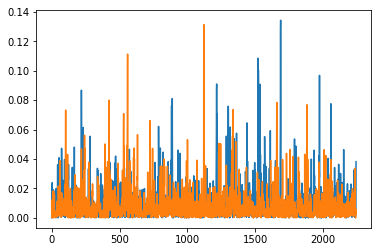

In [156]:
plt.plot([row[0] for row in phis])
plt.plot([row[1] for row in phis])